# Part II - Analysis of Prosper Loan Data

## Investigation Overview

> The investigation was focused on gaining insights on loan performance and risk-related variables, as well as exploring potential correlations. To accomplish this work focused on a historical subset of loans; loans that have been successfully "Completed" (i.e. good loans) as well as "Chargedoff" loans (i.e. bad loans). Within the confines of this subset, Lender Yield (perf.), Income Ranges (risk), Loan Categories (risk), and influence of time (considering the 2007-2008 Great Recession) were investigated.

## Dataset Overview
> The Prosper Loan Dataset is a large master dataset with approx. 114k rows and 81 columns. The data spans an approximately ~8-year period (11-2005 to 03-2014). The dataset was fairly clean and tidy, however some unnecessary columns and rows with NaNs were dropped; once the dataset was cleaned the historical subset dataframe was created (approx. 55k rows by 38 columns).



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from matplotlib import rcParams

# working with date/time dtypes
import datetime as dt

# generating combinations
from itertools import product

# setting random seed
np.random.seed(2018)

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# drop the duplicated key rows and assign the remaing rows to a new working ('dfw') dataframe
dfw = df.loc[df['ListingKey'].duplicated() == False]

# remove columns that have nulls (for now...may add back some variables later)
dfw = dfw.loc[:,(dfw.isnull().sum() == 0)]

print(dfw.shape)

(113066, 38)


In [4]:
# removing rows based on LoanStatus...keeping the 2 statuses we are focusing on...
dfw = dfw.loc[(dfw['LoanStatus'] == 'Completed') | (dfw['LoanStatus'] == 'Chargedoff')]
print(f'Dataframe shape: {dfw.shape}')
print(f'Nulls qty.: {dfw.isnull().sum().sum()}\n')

Dataframe shape: (50053, 38)
Nulls qty.: 0



## Loan Status Distribution


>Roughly ~10% and ~33% fall into the "Chargedoff" and "Completed" buckets (i.e. collectively they amount to roughly ~43-44% of the master (unmodified) dataset, which is more than ample for an investigation.


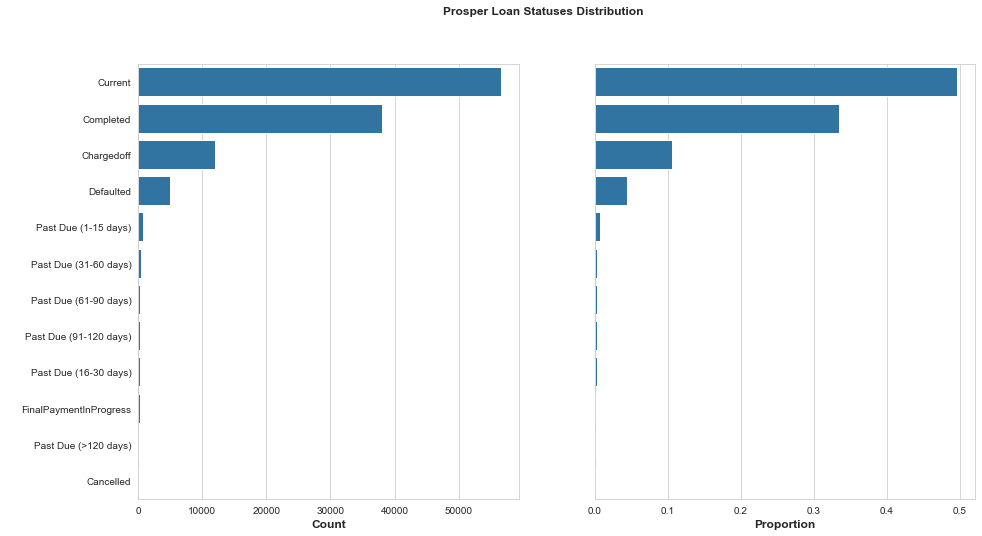

In [5]:
# plot bar charts for a qualitative nominal variable - counts & proportions

# set grid line style to facilitate reading the charts
#sb.set_theme()
sb.set_style("whitegrid")

# Specify the figure size, subplots, and title
rcParams['figure.figsize'] = 15,8
fig, [ax1, ax2] = plt.subplots(1,2)
fig.suptitle('Prosper Loan Statuses Distribution', size=12, weight='bold')

# choose single color 
base_color = sb.color_palette()[0]

# dynamically order bars
freq = df['LoanStatus'].value_counts()
freq_order = freq.index

# plot seaborn bar chart
sb.countplot(data=df, y='LoanStatus', color=base_color, order=freq_order, ax=ax1)

ax1.set_ylabel(' ', size=12, weight='bold')
ax1.set_xlabel('Count', size=12, weight='bold')

#-----plot 2-----

# Counts of the unique values in the series 
cat_counts = df.LoanStatus.value_counts()
      
# labels for cat_counts series (already in order of greatest to least count)
cat_counts_order = cat_counts.index

# sum of the unique value counts
n_cat_counts = df.LoanStatus.value_counts().sum()

# prop for highest frequency in the cat_counts column
max_prop = cat_counts[0] / n_cat_counts

# Use numpy.arange() function to produce a set of evenly spaced proportioned values 
tick_props = np.arange(0, max_prop+.1, 0.1)
tick_props

# Use a list comprehension to create tick_names that we will apply to the tick labels. 
tick_names = ['{:0.1f}'.format(v) for v in tick_props]
tick_names

# plot
sb.countplot(data=df, y='LoanStatus', color=base_color, order=cat_counts_order, ax=ax2);

# Change the tick locations and labels
plt.xticks(tick_props * n_cat_counts, tick_names)
plt.yticks([]) # suppress yticks on subplot

plt.ylabel('');
ax2.set_xlabel('Proportion', size=12, weight='bold');

#no legend needed here; unnecessary chart ink.

## Quarterly Aggregate (Original) Loan Amounts & Average Lender Yield

> The main observation from this plot is the severe downturn in loans/borrowing brought on by the Great Recession 2007-2008. Some other effects of the crisis can be seen in later plots as well.
>
>A couple of additional interesting observations here are that the Lender Yield variable stayed fairly resilient through the rough financial patch (perhaps they had a lot of fixed rate loans on their books); and, it actually ended the charted-period well above were it began (in contrast to the Loans Amount variable which ended the period almost where it began).


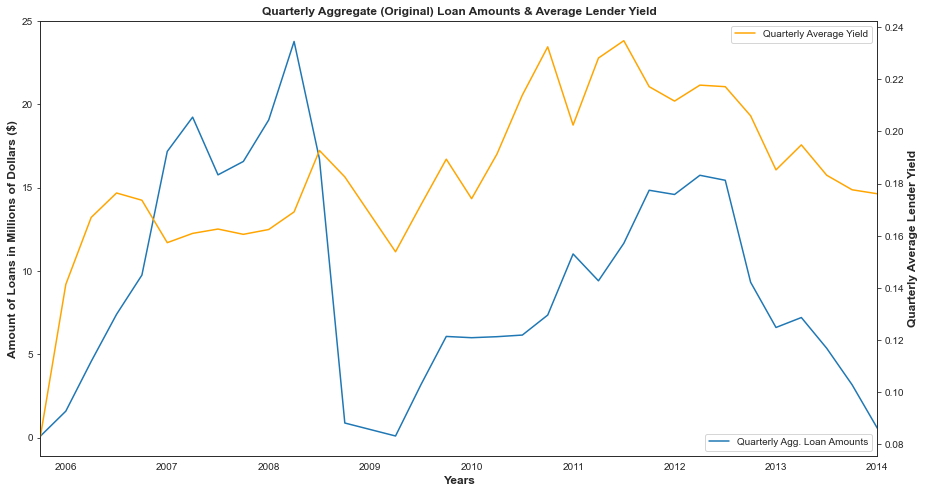

In [6]:
# quarterly quarter-end loan original amount totals
dfw['ListingCreationDate'] = pd.to_datetime(dfw.ListingCreationDate)
qtrly_loan_amts = dfw.groupby(dfw['ListingCreationDate'].dt.to_period('Q'))['LoanOriginalAmount'].sum()

# quarterly 'LenderYield' means series
qtrly_mean_yield = dfw.groupby(dfw['ListingCreationDate'].dt.to_period('Q'))['LenderYield'].mean()

# change plot style (to avoid noisy double gridlines)
sb.set_style('white')

# create fig and graph (ax)
fig, ax = plt.subplots(figsize=(15,8))

# line plots
line1 = qtrly_loan_amts.plot(ax=ax, label='Quarterly Agg. Loan Amounts')

ax.legend(loc='lower right');

# ax labels (and legend if used)
ax.set_title('Quarterly Aggregate (Original) Loan Amounts & Average Lender Yield', size=12, weight='bold')
ax.set_ylabel('Amount of Loans in Millions of Dollars ($)', size=12, weight='bold')
ax.set_xlabel('Years', size=12, weight='bold');

# get and set first plot y-ticks
y_ticks, y_labels = plt.yticks()
plt.yticks(y_ticks[1:], ['0', '5', '10', '15', '20', '25'])

# instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()  

# 2ndary axis label, plot with different line color
ax2.set_ylabel('Quarterly Average Lender Yield', size=12, weight='bold') 
color = 'tab:orange'
line2 = qtrly_mean_yield.plot(ax=ax2, color="orange", label='Quarterly Average Yield');

ax2.legend(loc='upper right');

## Income Ranges by Loan Status (Pre/Post-Crisis)

> This faceted bar plot really illustrates how lending practices were not as strict prior to the crash, and it highlights the potential risks - there are stark differences between the facets, for example:
>* Pre-crisis there were about 6,000 'Not Displayed" loans on the books (i.e. no income recorded...this seems risky!)
>* Post-crisis you can see that there are zero (0) "Not Displayed" instances, and the 3 other low/no-income bins are fairly small (and at the same time the bars representing the higher incomes are much larger, especially the "Complete" (i.e. successful) loans).
>* So it appears that the lender has really improved its application/loaning practices post crisis.

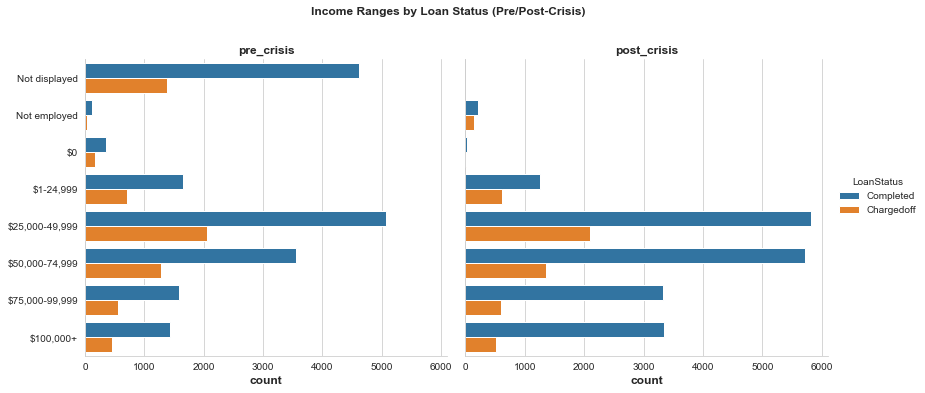

In [7]:
# ordered list of categories
reorder = ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']

# create new column to hold categorical variable pre-crisis vs post-crisis
dfw['crisis'] = np.nan

# create threshold for assigning pre-crisis vs post-crisis lending habits/practices

# Used end of 2008/ start of 2009 as the pre/post-crisis break (based on the 
# line charts above, it didn't look like lending started again until around this time) 
crisis_ts = pd.Timestamp(year=2008, month=12, day=31)

for i in range(dfw.shape[0]):
    if dfw['ListingCreationDate'].iloc[i] > crisis_ts:
        dfw['crisis'].iloc[i] = 'post_crisis'
    elif dfw['ListingCreationDate'].iloc[i] <= crisis_ts:
        dfw['crisis'].iloc[i] = 'pre_crisis'

        # set grid line style to facilitate reading the charts
sb.set_style("whitegrid")

# catplot (essentially FacetGrid with Countplot)
g = sb.catplot(y="IncomeRange", hue="LoanStatus", col='crisis', kind="count", palette='tab10',
           data=dfw, order=reorder, aspect=1.2, ci=None, legend_out=True, sharey=True, ax=ax)
# title
g.set_titles('{col_name}', size=12, weight='bold')
g.set_ylabels('') # removed because we have it in the title (and labels are descriptive)
g.set_xlabels(size=12, weight='bold')

plt.suptitle('Income Ranges by Loan Status (Pre/Post-Crisis)', y=1.08, size='large', weight='bold');


## Top 3 Loan Listing Categories (Pre/Post-Crisis) with Loan Status
>Key observations from the plot include:
>* Post-crisis there were zero (0) ambiguous "Not Available" loans listed. 
>* Post-crisis there was a dramatic increase in 'Debt Consolidation" loans (which seems understandable based on the financial crash).
>* The number of 'Chargedoff" loans were less post crisis.
>* Again, overall lending practices improved post crisis, thereby reducing risk and improving investment prospects.



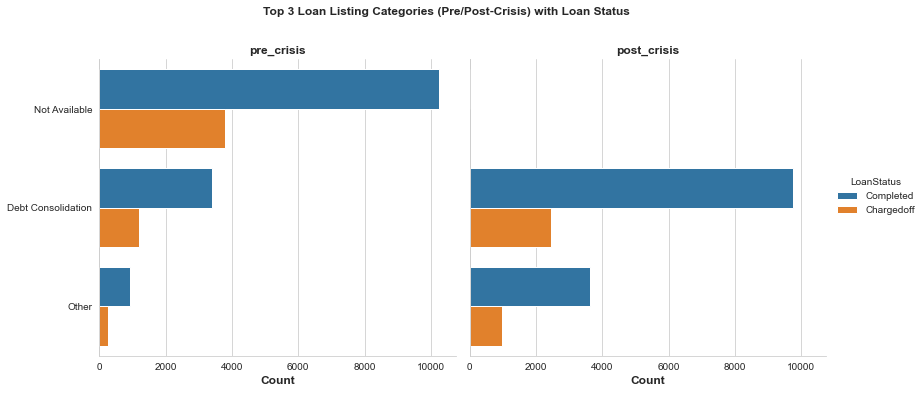

In [8]:
# copy paste variable definitions and remove numeric/symbolic portions
loan_cat_list = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
              'Auto', 'Other', 'Baby&Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
              'Household Expenses', 'Large Purchases', 'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
              'Wedding Loans']

# create indexed object (i.e. series) for matching
loan_cats = pd.Series(loan_cat_list)

# create new/working dataframe column
dfw['LoanCat'] = np.nan 

# loop to assign string based on numeric match
for row in dfw.index:
    match = dfw['ListingCategory (numeric)'].loc[row]
    dfw['LoanCat'].loc[row] = loan_cats[match]

# set grid line style to facilitate reading the charts
sb.set_style("whitegrid")

# top3 categories query (generate date for plot)
df_top3_cats = dfw.query('(LoanCat == "Not Available") | (LoanCat == "Debt Consolidation") | (LoanCat == "Other")')

# catplot (essentially FacetGrid with Countplot)
g = sb.catplot(y="LoanCat", hue="LoanStatus", col='crisis', kind="count", palette='tab10',
           data=df_top3_cats, order=None, aspect=1.2, ci=None, legend_out=True, sharey=True)
# title
g.set_titles('{col_name}', size=12, weight='bold')
g.set_ylabels('', size=12, weight='bold') # removed because we have it in the title (and labels are descriptive)
g.set_xlabels('Count', size=12, weight='bold')

# labeling
plt.ylabel(' ')
plt.suptitle('Top 3 Loan Listing Categories (Pre/Post-Crisis) with Loan Status', y=1.08, size=12, weight='bold');

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck_template.ipynb to slides
[NbConvertApp] Writing 762048 bytes to Part_II_slide_deck_template.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck_template.slides.html
Use Control-C to stop this server
